In [11]:
import pandas as pd
from sklearn import linear_model
from sklearn import svm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import skfeature
from scipy import stats
from sklearn import metrics
import numpy as np
%matplotlib inline

# An Introduction to Feature Engineering

By Eric Schles

Today we are going to cover feature engineering.  We'll start with the easiest form of feature engineering - creating dummy variables.  And then we'll move onto taking the log of diffierent variables, taking the variable and the square of variables, adding the results of other models as features to the model, and finally automatic feature selection, via skfeature and sklearn.  

To summarize we'll cover:

* dummy variables
* logs of variables
* boolean values
* multiplying variables
* features from exogenous data
* the outputs of other models as features
* automatic feature selection via skfeature
* automatic feature selection via PCA
* automatic feature selection via TSNE
* automatic feature selection via DBSCAN

In [12]:
# first let's import some data

train = pd.read_csv("train.csv")

# A brief introduction to Dummy variables

A dummy variable is a transformation of a categorical variable into a numeric variable.  This allows us to process a whole new set of data points, that we couldn't before.  However, there are some dangers.  We shouldn't interpret dummy variables as truly numeric, because there isn't necessarily a meaning to the transformation we choose.  As long as we map to variables that don't have large magnitudinal differences, and there are only a few categories, dummy variables give us a lot of power.

But if we have a ton of categories, a strict dummy variable mapping may be ill advised.

In [ ]:
# starting with dummy variables
# We'll want to pick dummary variables that occur a somewhat balanced number of times
# that makes variables like the following poor choices:

train["Street"].value_counts()

In [ ]:
# And variables like LotShape pretty good:
train["LotShape"].value_counts()

## Operationalizing dummy variables

Now that we've figured out what a good dummy variable looks like, let's operationalize it with a function!  

In [ ]:
def generate_dummy_variables(df, length_cut_off_percent = 0.75, max_concentration = 0.65):
    candidate_columns = []
    for column in df.columns:
        if df[column].dtype == object:
            candidate_columns.append(column)
    
    for column in candidate_columns:
        value_counts = df[column].value_counts()
        if len(value_counts) < len(df)*length_cut_off_percent: 
            candidate_columns.remove(column)
            continue
        sum_vals = sum(value_counts)
        percentages = [elem/sum_vals > max_concentration for elem in value_counts]
        if any(percentages):
            candidate_columns.remove(column)
        continue
    
    for column in candidate_columns:
        dummy_columns = pd.get_dummies(df[column])
        df = pd.concat([df, dummy_columns], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df

In [ ]:
# now let's see which variables we are going to turn into dummies
train_with_dummies = generate_dummy_variables(train)
print(train.shape, train_with_dummies.shape)

As you can see we went from 83 columns to 175.  That's a lot more features!  

# Logarithmic transformation

I'm not sure if logarithmic transformations are considered "feature engineering" however they are a powerful tool used often in econometrics to bring flexibility to the modeling of data.  In order to make use of and interpret this next technique we will need some information about our dataset.  Does it makes sense to take the log of any of the variables?

One of the ways you can tell this, is if the dependent variable and the independent variables are not in the same scale.  Which is often the case when dealing with prices.  So let's go ahead and build a rather standard model with our data:

`log(SalePrice) = B[0] + B[1]*LotArea + B[2]*BedroomAbvGr + B[3]*ExterQual + B[4]*OverallQual + B[5]*OverallCond + u`

```
SalePrice = the price the house was sold for 
LotArea = the size of the lot
BedroomAbvGr = the number of bedrooms above basement level
OveralQual = Rates the overall material and finish of the house
OverallCond = Rates the overall condition of the house
ExterQual = the quality of the exterior of the home (See Note)
```

Note - Even though these are categorical variables, there is an ordering to each variable Excellent, Good, Average, Fair and Poor.  So we can translate these variables into numeric ones.

In [13]:
mapping = {
    "Ex": 5, # Excellent
    "Gd": 4, # Good
    "TA": 3, # Average/Typical
    "Fa": 2, # Fair
    "Po": 1 # Poor
}
train["ExterQual"] = train["ExterQual"].map(mapping)


In [18]:
train["log_SalePrice"] = np.log(train["SalePrice"])

sale_price = train["log_SalePrice"]
X = train[["LotArea", "BedroomAbvGr", "ExterQual", "OverallQual", "OverallCond"]]
X = sm.add_constant(X)

In [19]:
model = sm.OLS(sale_price, X)

In [20]:
model_results = model.fit()

In [21]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     797.1
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        06:49:56   Log-Likelihood:                 231.80
No. Observations:                1460   AIC:                            -451.6
Df Residuals:                    1454   BIC:                            -419.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.0387      0.050    202.579      0.000       9.941      10.136
LotArea       6.529e-06   5.49e-07     11.890      0.000    5.45e-06    7.61e-06
BedroomAbvGr     0.0631      0.007      9.312      0.000       0.050       0.076
ExterQual        0.1537      0.014     11.040      0.000       0.126       0.181
OverallQual      0.1823      0.006     31.444      0.000       0.171       0.194
OverallCond      0.0183      0.005      3.731      0.000       0.009       0.028
==============================================================================
Omnibus:                      210.533   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.285
Skew:                          -0.733   Prob(JB):                    5.02e-138
Kurtosis:                       5.871   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Understanding how to think about logs in linear models

Generally speaking when one applies a log to the dependent variable of an OLS model, we are asking "What is the elasticity of sale price with respect to lot area, number of above ground bedrooms, external quality of the material of the house, overall quality of the house and overall condition of the house?"  Thinking of this another way, we can see this as the percentage change in price with respect to a change in a dependent variable.  

Thus, we have put our dependent variable in relative, not absolute terms to our independent variables.  In terms of a percentage change, things can be misleading, if not well understood.  But when treated carefully, percentage changes can shed more light than just dealing with absolute numbers.  Especially when changes in Y appear insensitive to changes in X, due to scaling reasons.  

This that in mind, let's look at our results!

Looking at our model:

We can say that Overall Quality has a large and statistically significant effect on the percentage change in the sale price for a house.  This seems to be the largest factor, with External Quality coming in second and number of bedrooms coming in third.  It's possible that higher quality materials are only used in larger more well cared for houses.  So it might be the case, that there is some correlation between the three variables.

In [23]:
print(stats.pearsonr(X["ExterQual"], X["OverallQual"]))
print(stats.pearsonr(X["BedroomAbvGr"], X["OverallQual"]))

(0.7262784907641429, 1.2901524338571525e-239)
(0.10167635624178528, 9.949911037119167e-05)


Unsurprisingly, there is a strong correlation between all three variables.  So we can drop ExterQual for sure.  We can also see what happens to the model statistics - R^2, AIC, BIC and the t-tests of specific variables, to determine if we should drop both variables.

In [24]:
X = train[["LotArea", "BedroomAbvGr", "OverallQual", "OverallCond"]]
X = sm.add_constant(X)
model = sm.OLS(sale_price, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     891.9
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        06:59:33   Log-Likelihood:                 173.04
No. Observations:                1460   AIC:                            -336.1
Df Residuals:                    1455   BIC:                            -309.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.3368      0.043    239.067      0.000      10.252      10.422
LotArea        6.43e-06   5.71e-07     11.253      0.000    5.31e-06    7.55e-06
BedroomAbvGr     0.0533      0.007      7.621      0.000       0.040       0.067
OverallQual      0.2289      0.004     55.369      0.000       0.221       0.237
OverallCond      0.0127      0.005      2.503      0.012       0.003       0.023
==============================================================================
Omnibus:                      179.440   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.137
Skew:                          -0.691   Prob(JB):                     1.97e-95
Kurtosis:                       5.293   Cond. No.                     1.12e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping ExterQual seems to have worked out nicely!  The R^2 doesn't fall much and none of the variables become statistically insignificant.  So we can safely drop ExterQual.

Next let's see if we can drop BedroomAbvGr.

In [25]:
X = train[["LotArea", "OverallQual", "OverallCond"]]
X = sm.add_constant(X)
model = sm.OLS(sale_price, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     1126.
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        07:01:03   Log-Likelihood:                 144.47
No. Observations:                1460   AIC:                            -280.9
Df Residuals:                    1456   BIC:                            -259.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4620      0.041    256.599      0.000      10.382      10.542
LotArea      6.909e-06   5.79e-07     11.934      0.000    5.77e-06    8.04e-06
OverallQual     0.2318      0.004     55.235      0.000       0.224       0.240
OverallCond     0.0136      0.005      2.622      0.009       0.003       0.024
==============================================================================
Omnibus:                      176.718   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.143
Skew:                          -0.693   Prob(JB):                     7.13e-91
Kurtosis:                       5.215   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R^2 didn't change much, but the AIC fell 56 points from -336 to -280.  So it might be worth including bedrooms in the model.  How it's best to look at alternative features before including ones with only marginal effects.  Also, the simplest sufficiently useful model is always the best.



Let's do one more experiment -

What happens if we take the log with respect to LotArea?  A good reason to take the log of this variable is that it is likely much larger than the other variables under consideration.  And so a linear model cannot capture it well.

In [26]:
train["log_SalePrice"] = np.log(train["SalePrice"])
train["log_LotArea"] = np.log(train["LotArea"])

sale_price = train["log_SalePrice"]
X = train[["log_LotArea", "OverallQual", "OverallCond"]]
X = sm.add_constant(X)

In [27]:
model = sm.OLS(sale_price, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     1352.
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        07:09:22   Log-Likelihood:                 240.44
No. Observations:                1460   AIC:                            -472.9
Df Residuals:                    1456   BIC:                            -451.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.7446      0.099     88.094      0.000       8.550       8.939
log_LotArea     0.2024      0.011     19.158      0.000       0.182       0.223
OverallQual     0.2235      0.004     56.285      0.000       0.216       0.231
OverallCond     0.0129      0.005      2.655      0.008       0.003       0.022
==============================================================================
Omnibus:                      233.333   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              715.041
Skew:                          -0.803   Prob(JB):                    5.38e-156
Kurtosis:                       6.029   Cond. No.                         230.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Perhaps unsurprisingly, our overall model performance improves, and now log_LotArea has a reasonably large coefficient, at least compared to before we took the log.  But how to interpret this parameter now?

Well, holding all other variables constant, a 1% change in log_LotArea leads to a (0.01)*0.2024 ~ 0.002 percent change in sale price.  Which appears small, but can actually be an amount of money worth consideration, depending on the house. 

# Adding Boolean Values

Another way we can make our model better is by teasing out specific effects at certain levels.  Maybe a variable that's continuous should be categorical?  But how to do this?  Well there are a few major techniques:

1. Singling out specific values - this is an equality boolean
2. Setting thresholds - this is when you look to see if the given value is above or below a specific value
3. High pass and low pass - this is when you look to see if a value is at it's extremes

Let's consider our model and a new variable who's scale makes it a little hard to work with - `YearBuilt`.

YearBuilt is the original construction date

Before we can define an appropriate transformation we need to know what we are dealing with.  So let's do some exploratory analysis.

In [29]:
max(train["YearBuilt"]), min(train["YearBuilt"])

(2010, 1872)

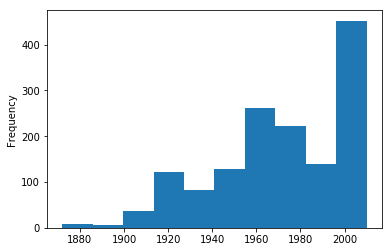

In [31]:
train["YearBuilt"].plot.hist()

It appears as though more houses have been built overtime, or the survival rate for a given house falls over time.  In any event, it gives us a natural information criteria for variable transformation:


`really_old := YearBuilt < 1920`

`reasonably_old := YearBuilt >= 1920 and YearBuilt < 1960`

`a_little_old := YearBuilt >= 1960 and YearBuilt < 1982`

`somewhat_new := YearBuilt >= 1982 and YearBuilt < 2008`

`brand_new := YearBuilt >= 2008`

The reason 2008 and forward is considered brand new is because the data only goes until 2010 and it takes time to build a house.

In [37]:
def reasonably_old(x):
    if x["YearBuilt"] >= 1920 and x["YearBuilt"] < 1960:
        return True
    else:
        return False

    
def a_little_old(x):
    if x["YearBuilt"] >= 1960 and x["YearBuilt"] < 1982:
        return True
    else:
        return False

def somewhat_new(x):
    if x["YearBuilt"] >= 1982 and x["YearBuilt"] < 2008:
        return True
    else:
        return False

boolean_map = {
    True: 1,
    False: 0
}
train["really_old"] = train["YearBuilt"] < 1920
train["reasonably_old"] = train.apply(reasonably_old, axis=1)
train["a_little_old"] = train.apply(a_little_old, axis=1)
train["somewhat_new"] = train.apply(somewhat_new, axis=1)
train["brand_new"] = train["YearBuilt"] >= 2008

train["really_old"] = train["really_old"].map(boolean_map)
train["reasonably_old"] = train["reasonably_old"].map(boolean_map)
train["a_little_old"] = train["a_little_old"].map(boolean_map)
train["somewhat_new"] = train["somewhat_new"].map(boolean_map)
train["brand_new"] = train["brand_new"].map(boolean_map)

In [38]:
train["log_SalePrice"] = np.log(train["SalePrice"])
train["log_LotArea"] = np.log(train["LotArea"])

sale_price = train["log_SalePrice"]
X = train[["log_LotArea", 
           "OverallQual", 
           "OverallCond", 
           "really_old", 
           "reasonably_old", 
           "a_little_old", 
           "somewhat_new", 
           "brand_new"]
         ]
X = sm.add_constant(X)

In [39]:
model = sm.OLS(sale_price, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     704.7
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        07:33:14   Log-Likelihood:                 349.79
No. Observations:                1460   AIC:                            -683.6
Df Residuals:                    1452   BIC:                            -641.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.2543      0.077     93.623      0.000       7.102       7.406
log_LotArea        0.2220      0.010     22.367      0.000       0.203       0.241
OverallQual        0.1742      0.005     34.155      0.000       0.164       0.184
OverallCond        0.0426      0.005      8.600      0.000       0.033       0.052
really_old         1.2810      0.025     51.883      0.000       1.233       1.329
reasonably_old     1.3252      0.019     68.802      0.000       1.287       1.363
a_little_old       1.4266      0.019     75.814      0.000       1.390       1.463
somewhat_new       1.5583      0.018     85.372      0.000       1.522       1.594
brand_new          1.6633      0.032     52.801      0.000       1.601       1.725
==============================================================================
Omnibus:                      220.512   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              918.531
Skew:                          -0.666   Prob(JB):                    3.50e-200
Kurtosis:                       6.650   Cond. No.                     2.10e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.06e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

So as we can see, some of the OverallQual and OverallCond are related to the year the house was built!  This appears clear from the size of the coefficent's on those two variables now as apposed to before.  Let's look at the correlations between these variables and the categorical variables.

In [48]:
print(stats.pearsonr(train["OverallQual"], train["reasonably_old"]))
print(stats.pearsonr(train["OverallQual"], train["really_old"]))
print(stats.pearsonr(train["OverallQual"], train["a_little_old"]))
print(stats.pearsonr(train["OverallQual"], train["somewhat_new"]))
print(stats.pearsonr(train["OverallQual"], train["brand_new"]))
print()
print(stats.pearsonr(train["OverallCond"], train["reasonably_old"]))
print(stats.pearsonr(train["OverallCond"], train["really_old"]))
print(stats.pearsonr(train["OverallCond"], train["a_little_old"]))
print(stats.pearsonr(train["OverallCond"], train["somewhat_new"]))
print(stats.pearsonr(train["OverallCond"], train["brand_new"]))

(-0.41356191390627833, 2.067718955357991e-61)
(-0.1201943389693286, 4.1169278356547164e-06)
(-0.24378009535094253, 3.3959083030753634e-21)
(0.5703948291588168, 9.14784007189097e-127)
(0.25438869055054214, 5.35693992261364e-23)

(0.19731322118479108, 2.788423398821179e-14)
(0.16135719004591492, 5.616132486368786e-10)
(0.1103711874771551, 2.3726607477861606e-05)
(-0.32511370797131084, 2.736066439219743e-37)
(-0.10006196270827494, 0.00012829835928363485)


So it seems as though OverallQual is actually a strongly related to age of the house.  Let's see what happens if we take out OverallQual and leave in reasonably_old, a_little_old, somewhat_new and brand_new.

As an aside, interestingly the effects are reversed for quality and condition!  This is surprising!

In [49]:
train["log_SalePrice"] = np.log(train["SalePrice"])
train["log_LotArea"] = np.log(train["LotArea"])

sale_price = train["log_SalePrice"]
X = train[["log_LotArea", 
           "reasonably_old", 
           "a_little_old", 
           "somewhat_new", 
           "brand_new"]
         ]
X = sm.add_constant(X)

In [50]:
model = sm.OLS(sale_price, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     352.6
Date:                Wed, 09 May 2018   Prob (F-statistic):          1.14e-247
Time:                        07:50:40   Log-Likelihood:                -151.67
No. Observations:                1460   AIC:                             315.3
Df Residuals:                    1454   BIC:                             347.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.0580      0.128     70.967      0.000       8.808       9.308
log_LotArea        0.2980      0.014     21.866      0.000       0.271       0.325
reasonably_old    -0.0170      0.032     -0.536      0.592      -0.079       0.045
a_little_old       0.1404      0.032      4.410      0.000       0.078       0.203
somewhat_new       0.5185      0.031     16.797      0.000       0.458       0.579
brand_new          0.7856      0.050     15.563      0.000       0.687       0.885
==============================================================================
Omnibus:                       81.008   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.074
Skew:                          -0.178   Prob(JB):                     1.67e-58
Kurtosis:                       5.061   Cond. No.                         169.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see model performance suffers significantly.  Which indicates there is an effect from age of house, but it is difficuilt for a linear model to get at.  Let's try a different tactic to get at this interaction, because there is certainly something here.

# Multiplying variables

There are two many ways to do multiplication of variables - to multiple variables together or takes powers of variables.

When you multiple variables together, you explicitly account for variables varying together.  So when you look at the multiplication of variables - you are answering the question, what happens when I look at the effect of x[1] and x[2]. When you look at powers of a variable, like a variable squared, you can account for diminishing returns of a variable, given that the sign on the coefficient is negative.

Let's start by trying to update our model, to include a multiplication of, `OverallQual` and `really_old` and  `OverallCond` and `really_old`.

`log(SalePrice) = B[0] + B[1]*log(LotArea) + B[2]*OverallQual + B[3]*OverallCond + B[4]*OverallQual*really_old + B[5]*OverallCond*really_old + u`



In [55]:
train["log_SalePrice"] = np.log(train["SalePrice"])
train["log_LotArea"] = np.log(train["LotArea"])
train["really_old_OverallQual"] = train["really_old"] * train["OverallQual"]
train["really_old_OverallCond"] = train["really_old"] * train["OverallCond"]


sale_price = train["log_SalePrice"]
X = train[["log_LotArea",
            "OverallQual", 
           "OverallCond",
           "really_old_OverallQual",
           "really_old_OverallCond"]
         ]
X = sm.add_constant(X)

In [54]:
model = sm.OLS(sale_price, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     845.5
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        08:01:28   Log-Likelihood:                 263.52
No. Observations:                1460   AIC:                            -515.0
Df Residuals:                    1454   BIC:                            -483.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8.7210      0.098     88.994      0.000       8.529       8.913
log_LotArea                0.2042      0.010     19.611      0.000       0.184       0.225
OverallQual                0.2239      0.004     56.760      0.000       0.216       0.232
OverallCond                0.0151      0.005      3.018      0.003       0.005       0.025
really_old_OverallQual    -0.0686      0.015     -4.631      0.000      -0.098      -0.040
really_old_OverallCond     0.0401      0.013      3.084      0.002       0.015       0.066
==============================================================================
Omnibus:                      249.840   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.897
Skew:                          -0.825   Prob(JB):                    1.70e-185
Kurtosis:                       6.356   Cond. No.                         230.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Features from Exogenous data

So far we've looked at how to make your models better by transforming the data you have.  But one of the most important kinds of feature engineering